In [216]:
import gc # сборщик мусора

import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
%matplotlib inline
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from lightgbm import LGBMRegressor


In [217]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [218]:
def nan_analize(X):
    nan_df = (X.isna().sum() / X.shape[0]).reset_index()
    nan_df.columns=['feature', 'nan_percent']

    plt.figure(figsize=(16,4))
    sns.barplot(nan_df['feature'], nan_df['nan_percent'])
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [219]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 5)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [220]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()

#**Загрузка данных**

In [710]:
df = pd.read_csv('Data set to train.csv')
df.head(10)

first_q = df.quantile(q=0.15)
third_q = df.quantile(q=0.99)

IQR = third_q-first_q
outliers = df[(df>(third_q+1.5*IQR))|(df<(first_q-1.5*IQR))].count(axis=1)
outliers.sort_values(axis=0, ascending = False, inplace=True)

outliers = outliers.head(950)
df.drop(outliers.index,inplace = True)

In [711]:
X = df.drop('median_house_value', axis=1)
y = df[['Id ', 'median_house_value']]

X.set_index('Id ', inplace=True)
y.set_index('Id ', inplace=True)

In [712]:
X_final = pd.read_csv('Data set to test X.csv')

first_q = df.quantile(q=0.15)
third_q = df.quantile(q=0.99)

IQR = third_q-first_q
outliers = X_final[(X_final>(third_q+1.5*IQR))|(X_final<(first_q-1.5*IQR))].count(axis=1)
outliers.sort_values(axis=0, ascending = False, inplace=True)

outliers = outliers.head(950)
X_final.drop(outliers.index,inplace = True)
X_final.set_index('Id ', inplace=True)
final_index_list = X_final.index

In [713]:
X = reduce_mem_usage(X)

Memory usage of dataframe is 0.98 MB
Memory usage after optimization is: 0.50 MB
Decreased by 48.7%


In [714]:
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 0.45 MB
Memory usage after optimization is: 0.23 MB
Decreased by 48.7%


#**Exploratory Data Analysis**

                    longitude  latitude  ...  households  median_income
longitude            1.000000 -0.924231  ...    0.048101      -0.020274
latitude            -0.924231  1.000000  ...   -0.063027      -0.073797
housing_median_age  -0.098417  0.000872  ...   -0.306868      -0.115773
total_rooms          0.036176 -0.026082  ...    0.916648       0.200977
total_bedrooms       0.063110 -0.059623  ...    0.980041      -0.015995
population           0.095753 -0.104583  ...    0.910878      -0.001242
households           0.048101 -0.063027  ...    1.000000       0.005810
median_income       -0.020274 -0.073797  ...    0.005810       1.000000

[8 rows x 8 columns]


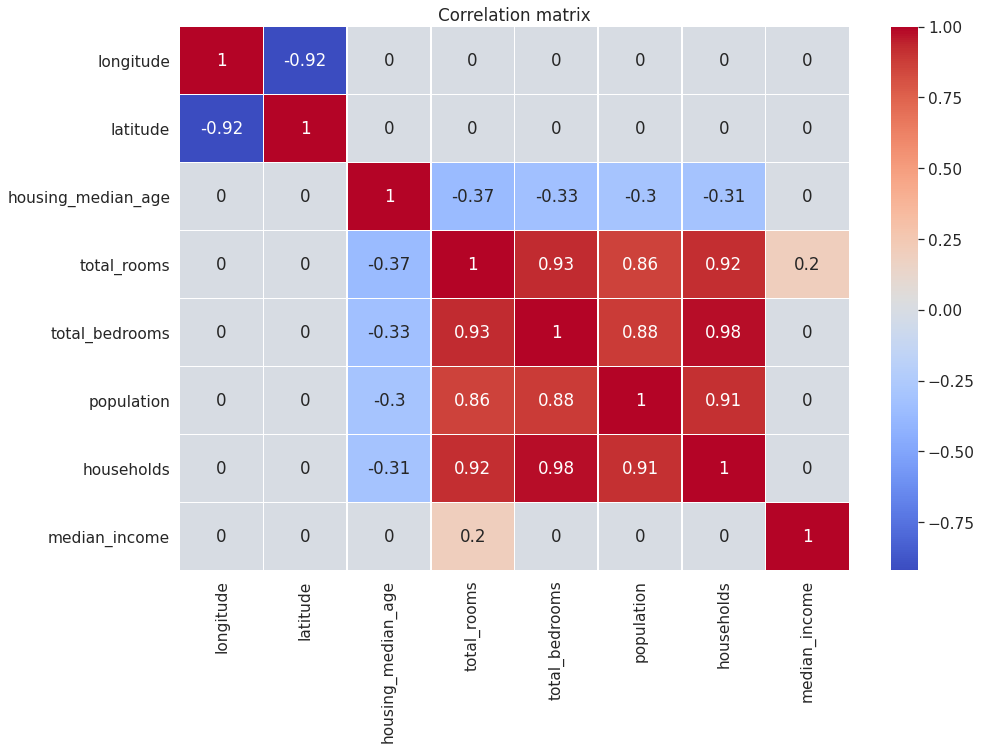

In [715]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X.corr()
print(X.corr())
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0 

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [716]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,12878.000000,12878.000000,12429.000000,12878.000000,12878.000000,12504.000000,12878.000000,12878.000000
mean,-119.586365,35.652054,28.584278,2639.053955,539.695435,1424.616821,500.899597,3.875742
std,2.006722,2.138224,12.550056,2066.816162,408.433014,1057.078247,371.517517,1.901647
min,-124.349998,32.549999,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.809998,33.939999,18.000000,1461.000000,298.000000,792.000000,281.000000,2.566775
50%,-118.500000,34.264999,29.000000,2139.000000,438.000000,1168.000000,413.000000,3.538950
75%,-118.010002,37.720001,37.000000,3172.000000,651.000000,1731.250000,608.000000,4.743925
max,-114.309998,41.950001,52.000000,25957.000000,4952.000000,12153.000000,4616.000000,15.000100


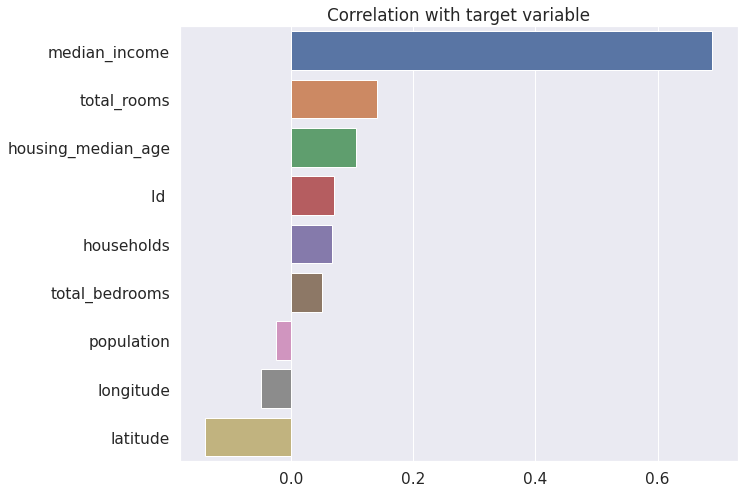

In [717]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [718]:
base_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity']

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


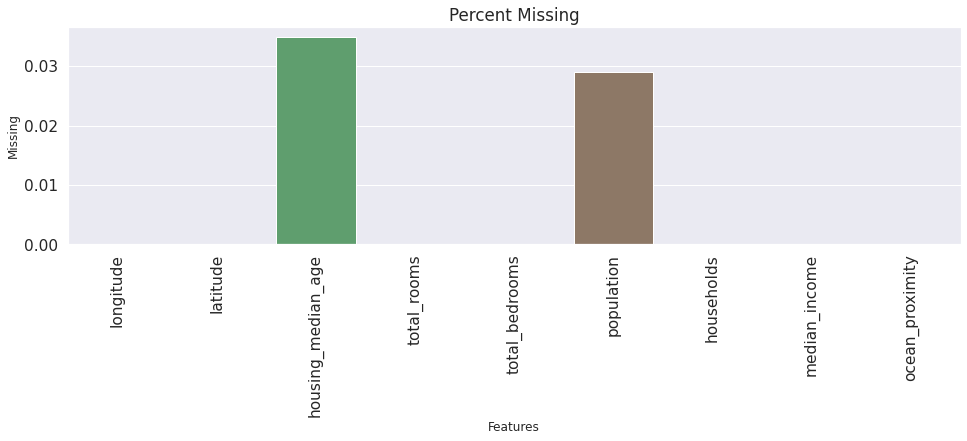

In [719]:
nan_analize(X)

# **Анализируем и исправляем**

In [720]:
median = X['housing_median_age'].median()
X['housing_median_age'] = X['housing_median_age'].fillna(median)
X_final['housing_median_age'] = X_final['housing_median_age'].fillna(median)

In [721]:
median = X['population'].median()
X['population'] = X['population'].fillna(median)
X_final['population'] = X_final['population'].fillna(median)

In [722]:
X.loc[X['longitude'] > 0, 'longitude'] = X.loc[X['longitude'] > 0, 'longitude'] * -1
X_final.loc[X_final['longitude'] > 0, 'longitude'] = X_final.loc[X_final['longitude'] > 0, 'longitude'] * -1


In [723]:
X['population_per_room'] = X['population'] / X['total_rooms']
X_final['population_per_room'] = X_final['population'] / X_final['total_rooms']

In [724]:

X['dist_to_tr'] = -(+0.70*X['longitude']+X['latitude']+(100))/(0.70**2 + 1)**0.5
X_final['dist_to_tr'] = (-0.61*X_final['longitude']-X_final['latitude']-(96.168))/(0.616**2 + 1)**0.5

In [725]:
#Примерное расстояние до побережья
X['dist_to_bank'] = (-0.79*X['longitude']-X['latitude']-127.8)/1.28
X_final['dist_to_bank'] = (-0.79*X_final['longitude']-X_final['latitude']-127.8)/1.28

In [726]:
#Расстояние до пляжа Санта-Круз

X['dist_to_SC'] = ((X['longitude']+122)**2+(X['latitude']-36.9744)**2)**0.5
X_final['dist_to_SC'] = ((X_final['longitude']+122)**2+(X_final['latitude']-36.9744)**2)**0.5

In [727]:
#Расстояние до пляжа Сан-Матео

X['dist_to_SM'] = ((X['longitude']+122.33)**2+(X['latitude']-37.5444)**2)**0.5
X_final['dist_to_SM'] = ((X_final['longitude']+122.33)**2+(X_final['latitude']-37544)**2)**0.5

In [728]:

X['dist_to_LA'] = ((X['longitude']+118)**2+(X['latitude']-33)**2)**0.5
X_final['dist_to_LA'] = ((X_final['longitude']+118)**2+(X_final['latitude']-33)**2)**0.5

In [729]:
X['dist_to_SF'] = ((X['longitude']+123)**2+(X['latitude']-37.7272)**2)**0.5
X_final['dist_to_SF'] = ((X_final['longitude']+123)**2+(X_final['latitude']-37.7272)**2)**0.5

In [730]:
#Расстояние до крупных городов

X['min_dist'] = np.minimum(X['dist_to_LA'], X['dist_to_SF'])
X_final['min_dist'] = np.minimum(X_final['dist_to_LA'], X_final['dist_to_SF'])

In [731]:
X['rooms_per_bedroom'] = X['total_rooms'] / X['total_bedrooms']
X_final['rooms_per_bedroom'] = X_final['total_rooms'] / X_final['total_bedrooms']

In [732]:
X['population_per_room'] = X['population'] /( X['total_rooms'])
X_final['population_per_room'] = X_final['population'] /( X_final['total_rooms'])

In [733]:
X['households_per_bedrooms'] =np.log(X['housing_median_age'])*np.log(X['dist_to_bank'])
X_final['households_per_bedrooms'] = (X_final['housing_median_age'])/(X_final['dist_to_bank'])

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


#**Проверка модели**

In [734]:
remain_features = ['longitude', 'min_dist','dist_to_LA','dist_to_SC','latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households','median_income', 'population_per_room', 'dist_to_bank','rooms_per_bedroom','ocean_proximity']

X = X[remain_features]
X_final = X_final[remain_features]

In [735]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [736]:
model = LGBMRegressor(max_depth=15,
                             min_samples_leaf=5,
                             n_estimators=250,
                             random_state=42)
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=15,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=5,
              min_split_gain=0.0, n_estimators=250, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

R2:	0.85911
RMSE:	43131.785
MSE:	1860350903.416


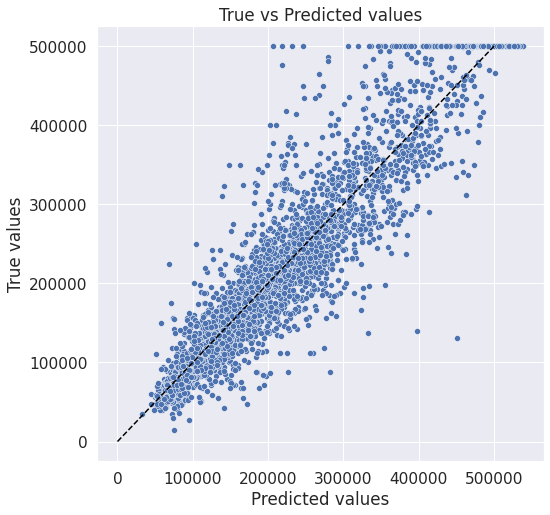

In [738]:
y_pred_test = model.predict(X_test)
evaluate_preds(y_test['median_house_value'], y_pred_test)

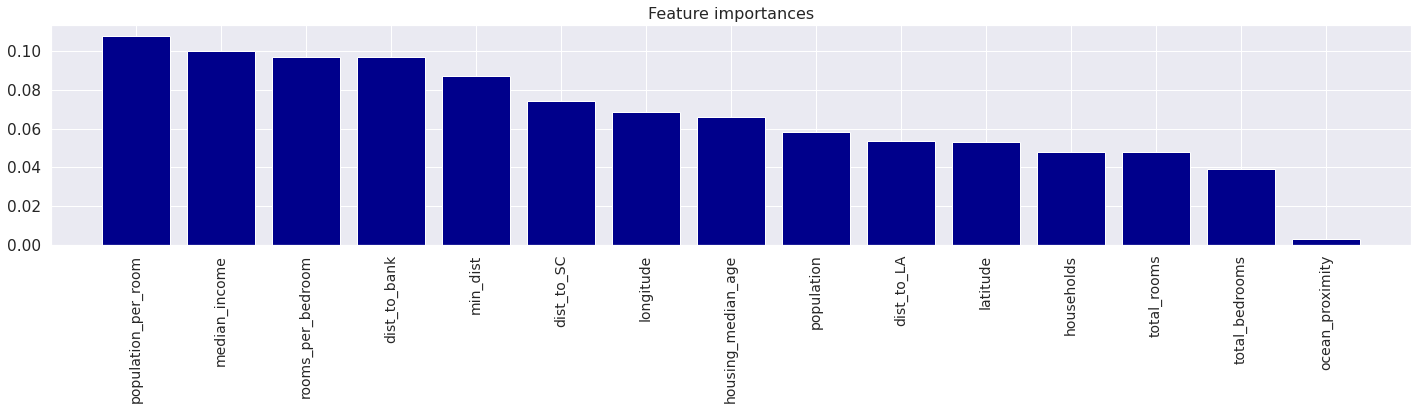

In [278]:
plot_feature_importances(importances = model.feature_importances_, X=X)

# **Учим финальную модель**

In [279]:
model_lgbm_f = LGBMRegressor(max_depth=15,
                             min_samples_leaf=5,
                             n_estimators=250,
                             random_state=42)
model_lgbm_f.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=15,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=5,
              min_split_gain=0.0, n_estimators=250, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [280]:
y_pred_test = model_lgbm_f.predict(X_final)
y_pred_df = pd.DataFrame(y_pred_test, columns=['median_house_value'])

In [282]:
filename = '201126_Danchenkov_2.csv'
y_pred_df.to_csv(filename, index=None)